# EDA of Amazon Electronics Reviews

## Patrick Crouch
## Group 9

In [1]:
from smart_open import open
import json
import pyspark

In [2]:
sc = pyspark.SparkContext()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/01 22:07:10 WARN Utils: Your hostname, MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 192.168.68.54 instead (on interface en0)
25/12/01 22:07:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/01 22:07:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
bucket = "msds-694-cohort-14-group9/data"
filename = "Electronics.jsonl"
path = f"gs://{bucket}/{filename}"

first_5000 = []

with open(path, "r") as f:
    for i, line in enumerate(f):
        if i >= 5000:
            break
        first_5000.append(json.loads(line))

/Users/patri/miniconda3/envs/distributed_computing/lib/python3.13/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/patri/miniconda3/envs/distributed_computing/lib/python3.13/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [4]:
base_rdd = sc.parallelize(first_5000)

#### Question: Does the length of a review correlate to the rating?

In [5]:
average_review_length_by_rating = {}
for i in range(5):
    rating = i+1
    filtered_rdd = base_rdd.filter(lambda x: int(x['rating']) == rating)
    review_lengths = filtered_rdd.map(lambda x: len(x['text']))
    average_review_length = review_lengths.reduce(lambda x, y: x+y)/filtered_rdd.count()

    average_review_length_by_rating[rating] = round(average_review_length, 2)


In [6]:
average_review_length_by_rating

{1: 313.52, 2: 596.99, 3: 567.52, 4: 598.67, 5: 369.23}

It seems that review lengths are shorter for 1 and 5 ratings, and longer for the intermediate ratings. If I were to guess why this discrepancy exists, I would think that people who are rating 2, 3 and 4 are thinking more about their rating that those simply choosing the binary best or worst rating.

#### Question: What are the most common words seen in reviews for each rating?

In [7]:
# !pip install nltk
import nltk
from nltk.corpus import stopwords

# Set of common irrelevant words to not include
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/patri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def parse_review(text):
    problem_chars = ['.','><br','/', '-']
    filtered_text = text.lower()
    for c in problem_chars:
        filtered_text = filtered_text.replace(c,'')
    return filtered_text.split(' ')

top_words_by_rating = {}
for i in range(5):
    rating = i+1
    filtered_rdd = base_rdd.filter(lambda x: int(x['rating']) == rating)
    word_rdd = filtered_rdd.flatMap(lambda x: parse_review(x['text']))
    clean_word_rdd = word_rdd.filter(lambda x: x not in stop_words and x not in ['', '>'])

    n = clean_word_rdd.count()
    
    word_counts = clean_word_rdd.map(lambda word: (word, 1)).reduceByKey(lambda x, y: x + y)
    sorted_word_counts = word_counts.sortBy(lambda x: x[1], ascending=False)
    sorted_word_ratios = sorted_word_counts.mapValues(lambda x: round(x/n, 5))

    top_words_by_rating[rating] = sorted_word_ratios.take(10)

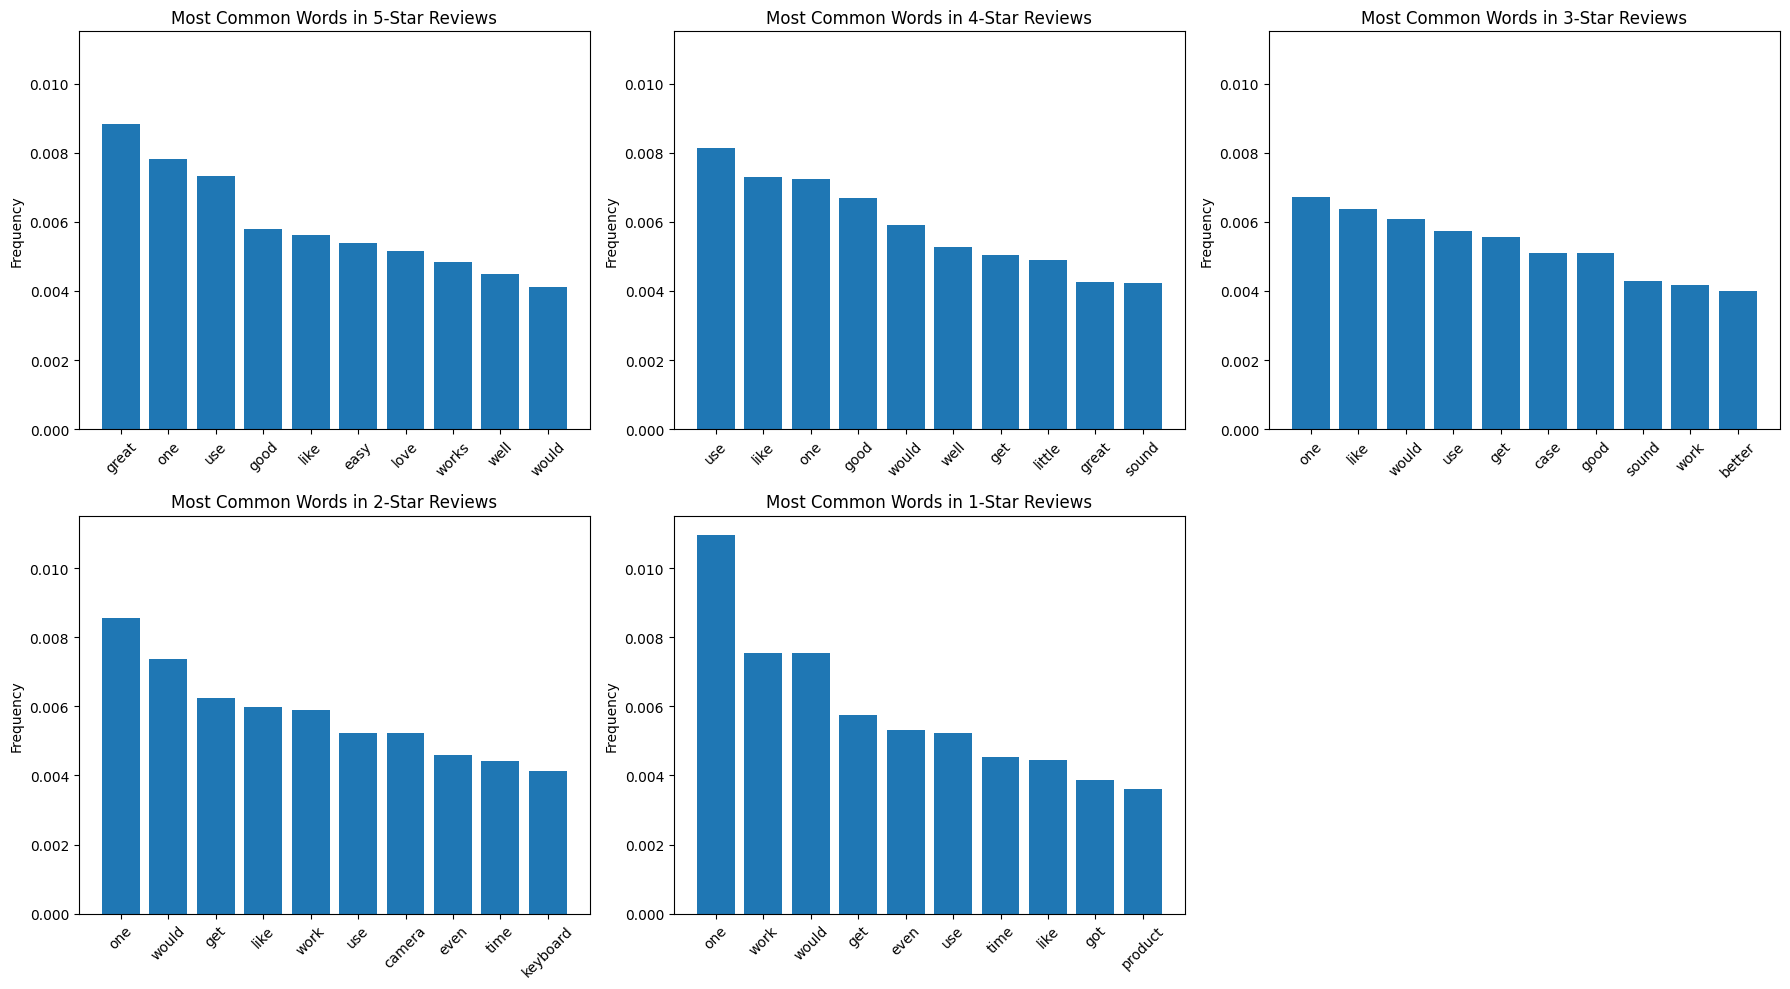

In [9]:
from matplotlib import pyplot as plt

all_freqs = [freq for key_values in top_words_by_rating.values() for _, freq in key_values]
max_freq = max(all_freqs)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, key in enumerate([5, 4, 3, 2, 1]):
    words, freqs = zip(*top_words_by_rating[key])
    axes[i].bar(words, freqs)
    axes[i].set_title(f'Most Common Words in {key}-Star Reviews')
    axes[i].set_ylabel('Frequency')
    axes[i].set_ylim(0, max_freq * 1.05)
    axes[i].tick_params(axis='x', rotation=45)

axes[-1].axis('off')

plt.tight_layout()
plt.show()

We can see that some words, like "one", "use", and "get" appear frequently in all reviews. These make sense as words that would be used in a review of any kind. "like" also appears in the top 10 for all reviews, but this could mean the word "like" is used as a preposition, not a verb. For example, "This product smells like garbage".

As one would expect, words like "great", "good", and "love" appear as words for high rating reviews. Interestingly, "better" appears frequently in 3-star reviews, suggesting reviewer is saying the product could be better.

Some interesting common words for low star reviews are "work" and "even". I suspect these words are used in a way like "This product doesn't even work". We can also see that "works" is a common word for 5-star reviews. This is interesting because in english we say "This product works" and say "This product doesn't work", which I assume is why we see "works" in good reviews and "work" in bad reviews.